In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import logging

project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from zeru_credit_score.loader import load_transactions
from zeru_credit_score.features import engineer_features
from zeru_credit_score.scoring import calculate_scores
from zeru_credit_score.logging_config import setup_logging

setup_logging(logging.INFO)

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 150)

sns.set_theme(style="whitegrid")


In [ ]:
DATA_DIR = os.path.join(project_root, 'data')
BASE_WEIGHTS = {"health": 0.45, "trust": 0.35, "risk": 0.20}

df_raw = load_transactions(DATA_DIR)
features_df = engineer_features(df_raw)
scored_df = calculate_scores(features_df, BASE_WEIGHTS, scaler_path=None)

print(f"\nPipeline complete. Scored {len(scored_df)} unique wallets.")
print("Here's a preview of the final scored data:")
scored_df.head()

2025-06-26 21:01:15 INFO     [zeru_credit_score.loader] Dropped 10627 duplicate transactions
2025-06-26 21:01:15 INFO     [zeru_credit_score.features] Starting feature engineering for 130110 records
2025-06-26 21:01:15 INFO     [zeru_credit_score.features] Completed features: 13873 wallets × 20 features
2025-06-26 21:01:15 INFO     [zeru_credit_score.scoring] Applying overrides: 0 liquidations, 2266 low-repay

Pipeline complete. Scored 13873 unique wallets.
Here's a preview of the final scored data:


,raw_deposits_usd,raw_borrows_usd,repayment_ratio,net_collateral_flow,health_factor,liquidation_count,ever_liquidated,account_age_days,unique_active_days,tx_count,asset_diversity,usd_amount_std,median_tx_gap_hours,tx_freq_per_day,log_net_collateral_flow,log_usd_amount_std,log_account_age_days,log_unique_active_days,log_median_tx_gap_hours,log_tx_freq_per_day,health_score,trust_score,risk_score,raw_score,score
wallet,,,,,,,,,,,,,,,,,,,,,,,,,
0x930a7cd60a633128b7c5181307781e6d033ba51a,2354.656793,0.0,1.0,1133.264411,1.133264e+12,0,0,147,9,9,2,455.958355,377.803194,1.0,15.745340,6.124592,4.997212,2.302585,5.937017,0.693147,0.953884,0.917974,0.749474,0.900434,90
0x12899167ebac6cfd96b61b18eaa5f91f9d859886,5120.066559,0.0,1.0,3120.066559,3.120067e+12,0,0,132,6,6,2,1101.386241,617.059444,1.0,15.745629,7.005232,4.890349,1.945910,6.426585,0.693147,0.968013,0.910549,0.734018,0.901102,90
0x2fa1859029a483defbb664bb6026d682f55e2fcd,5129.112256,0.0,1.0,1631.335945,1.631336e+12,0,0,123,11,11,2,350.225587,184.664028,1.0,15.745412,5.861429,4.820282,2.484907,5.223939,0.693147,0.959657,0.896860,0.753436,0.896434,90
0x7c76f4db70b7e2177de10de3e2f668dadcd11108,10836.466361,0.0,1.0,4304.523835,4.304524e+12,0,0,120,7,7,3,1130.718311,252.679722,1.0,15.745800,7.031492,4.795791,2.079442,5.536073,0.693147,0.972429,0.890635,0.768827,0.903081,90
0xad923feeeef3598217bd2d7d5d1181d8c386ca88,1481.704124,0.0,1.0,1481.704124,1.481704e+12,0,0,74,10,10,2,130.465491,136.943611,1.0,15.745391,4.878744,4.317488,2.397895,4.926845,0.693147,0.958386,0.861442,0.770629,0.886904,89


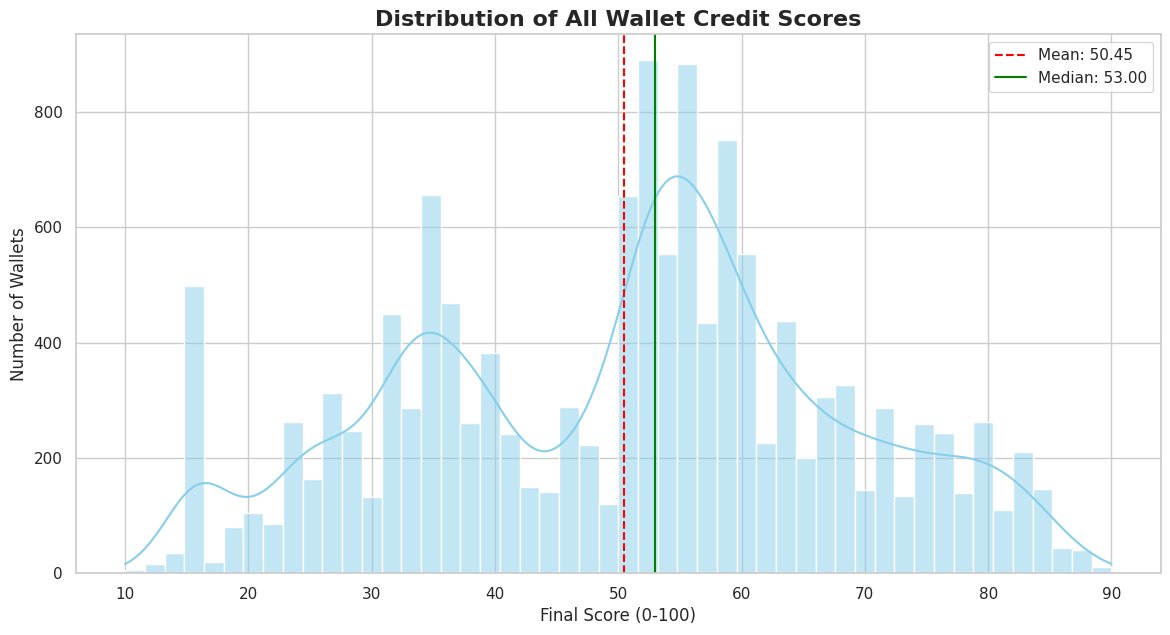

In [3]:
plt.figure(figsize=(14, 7))
sns.histplot(data=scored_df, x='score', bins=50, kde=True, color='skyblue')
plt.title('Distribution of All Wallet Credit Scores', fontsize=16, fontweight='bold')
plt.xlabel('Final Score (0-100)', fontsize=12)
plt.ylabel('Number of Wallets', fontsize=12)
plt.axvline(scored_df['score'].mean(), color='red', linestyle='--', label=f"Mean: {scored_df['score'].mean():.2f}")
plt.axvline(scored_df['score'].median(), color='green', linestyle='-', label=f"Median: {scored_df['score'].median():.2f}")
plt.legend()
plt.show()



## ANALYSIS OF TOP 20 WALLETS
Top wallets should show the following characterstics:
- A perfect or near-perfect score.
- Zero liquidations.
- A high repayment ratio (meaning they pay back their debts).


In [ ]:
top_20 = scored_df.head(20)
analysis_cols = [
    "score", "health_score", "trust_score", "risk_score",
    "ever_liquidated", "repayment_ratio", "account_age_days", "unique_active_days"
]

display(top_20[analysis_cols].style.background_gradient(
    cmap='Greens', subset=['score', 'health_score', 'trust_score', 'risk_score', 'repayment_ratio']
))

min_score = top_20['score'].min()
if min_score > 80:
    print(f"Success. Minimum score is {min_score}, which is high as expected.")
else:
    print(f"Failure. Minimum score is {min_score}, which is unexpectedly low for the top 20.")

liquidations = top_20['ever_liquidated'].sum()
if liquidations == 0:
    print("Success. Found 0 liquidations among the top 20 wallets.")
else:
    print(f"Failure. Found {liquidations} liquidated wallets in the top 20. This is a major red flag!")

avg_repayment = top_20['repayment_ratio'].mean()
if avg_repayment > 0.98:
    print(f"Success. Average repayment ratio is {avg_repayment:.3f}, which is excellent.")
else:
    print(f"Failure. Average repayment ratio is {avg_repayment:.3f}, which is lower than expected for top wallets.")

,score,health_score,trust_score,risk_score,ever_liquidated,repayment_ratio,account_age_days,unique_active_days
wallet,,,,,,,,
0x930a7cd60a633128b7c5181307781e6d033ba51a,90,0.953884,0.917974,0.749474,0,1.000000,147,9
0x12899167ebac6cfd96b61b18eaa5f91f9d859886,90,0.968013,0.910549,0.734018,0,1.000000,132,6
0x2fa1859029a483defbb664bb6026d682f55e2fcd,90,0.959657,0.896860,0.753436,0,1.000000,123,11
0x7c76f4db70b7e2177de10de3e2f668dadcd11108,90,0.972429,0.890635,0.768827,0,1.000000,120,7
0xad923feeeef3598217bd2d7d5d1181d8c386ca88,89,0.958386,0.861442,0.770629,0,1.000000,74,10
0xbc8dafeaca658ae0857c80d8aa6de4d487577c63,89,0.956076,0.890662,0.743263,0,1.000000,134,4
0xc7557ee5b5ac2f86df0764d12706f085ea77a845,89,0.961110,0.885820,0.741018,0,1.000000,115,5
0xc3fdadbae46798cd8762185a09c5b672a7aa36bb,89,0.989132,0.872650,0.713545,0,1.000000,95,4
0x7fce563e9f39ab7dfbd61978f10037cc32a95a4d,89,0.939887,0.886689,0.760659,0,1.000000,102,7


Success. Minimum score is 88, which is high as expected.
Success. Found 0 liquidations among the top 20 wallets.
Success. Average repayment ratio is 1.000, which is excellent.


**The top-ranked wallets exhibit a perfect risk profile. Key characteristics are zero liquidations, a flawless 1.0 repayment ratio, and an established history (account_age_days). They represent the most trustworthy users, and the model correctly places them at the top.**


## ANALYSIS OF BOTTOM 20 WALLETS
Lowest scoring wallets should show the following characterstics:
- A very low score.
- A history of being liquidated.
- A poor repayment ratio.


In [ ]:
bottom_20 = scored_df.tail(20)
analysis_cols_bottom = [
    "score", "health_score", "trust_score", "risk_score",
    "ever_liquidated", "liquidation_count", "repayment_ratio"
]

display(bottom_20[analysis_cols_bottom].style.background_gradient(
    cmap='Reds_r', subset=['score', 'health_score', 'trust_score', 'risk_score', 'repayment_ratio']
).highlight_max(subset=['ever_liquidated', 'liquidation_count'], color='#ffc7c7'))


max_score = bottom_20['score'].max()
if max_score < 30:
    print(f"Success. Maximum score is {max_score}, which is low as expected.")
else:
    print(f"Failure. Maximum score is {max_score}, which is too high for the bottom 20.")

liquidated_wallets = bottom_20['ever_liquidated'].sum()
poor_repayment_wallets = (bottom_20['repayment_ratio'] < 0.5).sum()

if liquidated_wallets > 0 or poor_repayment_wallets > 0:
    print(f"Success. Found expected risk factors ({liquidated_wallets} liquidations, {poor_repayment_wallets} wallets with very poor repayment).")
else:
    print(f"Failure. Did not find significant risk factors (liquidations or poor repayment) in the bottom 20. The model's logic may need review.")

,score,health_score,trust_score,risk_score,ever_liquidated,liquidation_count,repayment_ratio
wallet,,,,,,,
0xa417c523bebad1b712fec3822e1d58b8601b93b8,13,0.242621,0.111709,0.588871,0,0,0.000000
0xcf9060b126ed8995403d876e0f0bc3a1237bd8f9,13,0.253013,0.110701,0.530268,0,0,0.000000
0x361999adc5282d3a5dc101776596d2c8005f6c48,13,0.186868,0.149127,0.622080,0,0,0.000000
0x89e5adc8da38a3a5dd27d8fd9de1484eb26c7c04,13,0.356902,0.137119,0.262947,0,0,0.000000
0xf5eef5722742770ef62c8ca8e48144209d863ced,13,0.195641,0.173508,0.556842,0,0,0.000000
0x9da8e0f410c2efbadf1e7c4e1815d3757a5c4aff,13,0.191058,0.170033,0.593438,0,0,0.000000
0x385d84a0e3d88e91e8e1a3a5aadcd759670c468a,12,0.153398,0.176512,0.506368,0,0,0.000000
0x3dfe9a6c5473d9f2b5bd3171860eedbdbb7b0124,12,0.193560,0.118150,0.509835,0,0,0.216148
0x333ad11501e2a8123cfaf18d99edb494921b1eaf,12,0.184042,0.139914,0.548343,0,0,0.000000


Success. Maximum score is 13, which is low as expected.
Success. Found expected risk factors (0 liquidations, 20 wallets with very poor repayment).


**The lowest-scoring wallets are defined by their failure to repay loans. Note that ever_liquidated is zero for all; their risk comes entirely from a near-zero repayment_ratio. The model correctly identifies these "deadbeat borrowers" as a critical high-risk group.**
